In [24]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
import matplotlib.colors as colors
from sklearn.metrics import mean_squared_error, mean_absolute_error
import scipy
from scrape import *
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100
pd.set_option('display.max_colwidth', None)

RANDOM_STATE = 42

In [25]:
df = pd.read_csv('data/data_all_clean.csv')
df["bed_to_bath"] = df.apply(lambda row: max(1, row.num_bedrooms) / max(0.5, row.num_bathrooms), axis=1)
df.head()

,listing_id,available_at,months_available_for,address,unit_number,city,zip,contact_preference,contact_name,short_description,rent_amount,rent_type,pets_allowed,gender_preference,num_bedrooms,num_bathrooms,housing_type,gmap_latitude,gmap_longitude,expires_at,listing_within_city,created_at,overall_safety_rating,has_fire_resistant_construction_type,exceeds_requirements,meets_minimum_requirements,has_gender_preference,has_female_gender_preference,has_male_gender_preference,is_single_room,amenity_air_conditioning,includes_electricity,electronic_payments_allowed,includes_furniture,includes_heat,includes_internet,amenity_kitchen_available,amenity_laundry_available,is_near_bus,amenity_offstreet_parking_available,includes_offstreet_parking,psparking_available,includes_water,market_grad,market_faculty,market_ugrad,market_sabbatical,market_fall_sublet,market_spring_sublet,market_summer_sublet,market_short_term,distance_to_campus,price_per_room,price_per_unit,year,month,uuid,bed_to_bath
0,3262,2023-06-01 00:00:00+00:00,12,414 STEWART AVENUE,6 Bedroom,Ithaca,14850,BothEmailAndPhone,Mary Williams,Large 14 bedroom house - 2 Blocks from Campus,800,Price per Person,0,No Preference,14,2.0,Rent,42.442798,-76.490514,2023-03-07T00:00:00.000Z,Yes,2020-09-30 19:32:37+00:00,10.0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,1,1,1,0,0,0,1,1,1,0,0,0,0,0,705.534350,800.0,11200,2023,6,3262-2023-6,7.00
1,2602,2020-06-01 04:00:00+00:00,12,133 BLAIR STREET,NaN,Ithaca,14850,Both Email and Phone,Nick Lambrou,"Great location, excellent for fraternity/sorority/sports team. 8 bedrooms upstairs, 1 bedroom apartment included below. 3 kitchens, 4 bathrooms and 2-3 parking spots included",1045,Price per Person,1,No Preference,9,4.0,Rent,42.439343,-76.485656,2019-11-15T05:00:00.000Z,Yes,2017-09-12 17:38:06+00:00,8.0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,1,1,0,1,0,0,0,0,1,0,0,0,0,0,925.010846,1045.0,9405,2020,6,2602-2020-6,2.25
2,3247,2021-08-01 04:00:00+00:00,12,121 COLLEGE AVENUE,NaN,Ithaca,14850,Both Email and Phone,Patty Hollister,*Brand New* ONE Bedroom available at 121-125 College Avenue. In Collegetowm just blocks from Cornell Campus.,2450,Price per Unit,0,No Preference,1,1.0,Rent,42.438787,-76.485080,2021-04-17T04:00:00.000Z,Yes,2019-10-31 17:28:48+00:00,22.0,1,0,0,0,0,0,0,1,0,1,1,1,0,1,1,1,0,0,0,1,1,1,1,0,0,0,0,0,985.062927,2450.0,2450,2021,8,3247-2021-8,1.00
3,949,2019-01-21 05:00:00+00:00,12,233 Forest Home Drive,NaN,Ithaca,14850,Email Only,Rebecca Leistikow,This contemporary and adorable 1 bedroom garden apartment is located in the heart of the quaint and convenient Forest Home neighborhood - walking distance to Cornell!,2400,Price per Unit,0,No Preference,1,1.0,Rent,42.451352,-76.467622,2018-03-19T04:00:00.000Z,No,2018-01-07 18:28:29+00:00,NaN,0,0,0,0,0,0,0,0,1,1,0,1,1,1,1,1,0,1,0,1,1,1,0,0,0,0,0,0,1481.627891,2400.0,2400,2019,1,949-2019-1,1.00
4,3219,2021-08-18 04:00:00+00:00,10,409 COLLEGE AVENUE,N406,Ithaca,14850,Email Only,Hamid Waraich,Newly constructed luxury apartments in the most convenient location in Collegetown,2275,Price per Unit,0,No Preference,0,1.0,Rent,42.442479,-76.484997,2021-01-24T05:00:00.000Z,Yes,2019-10-09 15:09:53+00:00,18.0,1,0,0,0,0,0,0,1,0,1,0,1,1,1,1,0,0,0,0,0,1,0,1,0,0,0,0,0,574.548967,2275.0,2275,2021,8,3219-2021-8,1.00


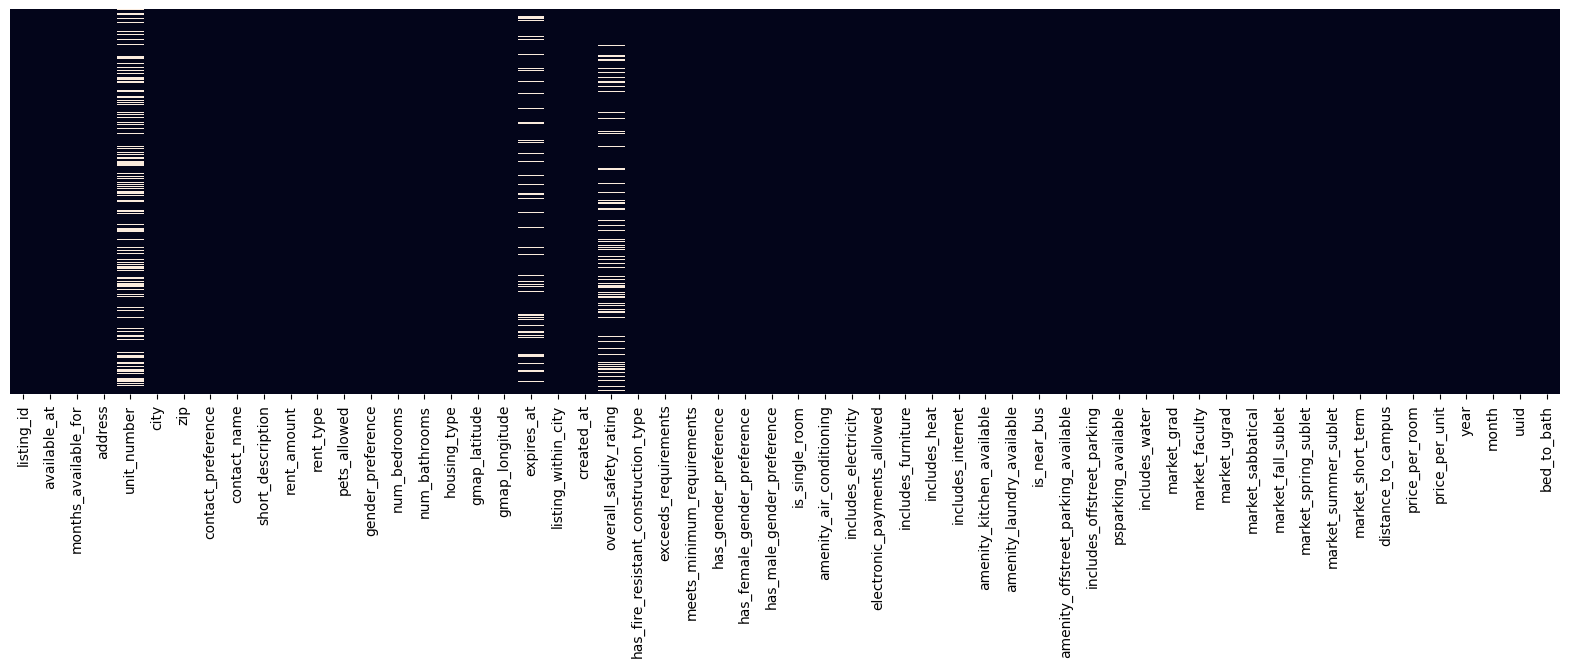

In [3]:
df.head()
fig = plt.figure(figsize=(20,5))
sns.heatmap(df.isna().sort_index(), 
        yticklabels=False, 
        cbar=False)
plt.show()

In [4]:
def apply_filter(df): 
    """
    """
    df = df.loc[df.market_spring_sublet == 0]
    df = df.loc[df.market_fall_sublet == 0]
    df = df.loc[df.market_summer_sublet == 0]
    df = df.loc[df.market_short_term == 0]
    df = df.loc[df.num_bedrooms <= 20]
    df = df.loc[df.price_per_unit <= 15000]
    df = df.loc[df.distance_to_campus <= 2500]
    return df 

# data2023 = pd.read_parquet("data/scrape_2023.parquet")
# data2021 = pd.read_parquet("data/scrape_2021.parquet")
# data2023 = apply_filter(data2023)
# data2023 = data2023.loc[:, data2023.columns != "listing_photos"]
# data2021 = apply_filter(data2021)
# df = pd.concat([data2021,data2023], axis=0)
# df = set_dtypes(df)
# df = df.loc[~df.uuid.duplicated(keep=False)]
# df.to_parquet('data/data_2021_and_2023.parquet', index=False)

# df.loc[df.uuid == '983-2021-8', ['rent_type', 'price_per_room']] = ["Price Per Unit", 3750.0/5]
# df.loc[df.uuid == '172-2018-8', ['rent_type', 'price_per_room']] = ["Price Per Person", 225*2]
# df.loc[df.uuid == '207-2017-9', ['rent_type', 'price_per_room']] = ["Price Per Person", 750]
# df.loc[df.uuid == '208-2019-8', ['rent_type', 'price_per_room']] = ["Price Per Person", 750]
# df.loc[df.uuid == '3948-2023-6', ['num_bedrooms', 'price_per_room']] = [4, 3000/4]
# df.loc[df.uuid == '976-2018-1', ['rent_type', 'price_per_room']] = ["Price Per Person", 610]
# df.loc[df.uuid == '394-2017-7', ['num_bedrooms', 'price_per_room']] = [2, 875.0/2] 
# df.loc[df.uuid == '726-2018-7', ['rent_type', 'price_per_room']] = ["Price Per Person", 750]
# df.loc[df.uuid == '773-2021-8', ['rent_type', 'price_per_room']] = ["Price Per Person", 745]
# df.loc[df.uuid == '1214-2018-7', ['rent_type', 'price_per_room']] = ["Price Per Person", 1200]
# df.loc[df.uuid == '1304-2019-9', ['rent_type', 'price_per_room']] = ["Price Per Person", 595]
# df.loc[df.uuid == '1305-2018-8', ['rent_type', 'price_per_room']] = ["Price Per Person", 595]
# df.loc[df.uuid == '111-2023-1', ['rent_type', 'price_per_room']] = ["Price Per Person", 550]
# df.loc[df.uuid == '2511-2020-6', ['rent_type', 'price_per_room']] = ["Price Per Person", 820]
# df.loc[df.uuid == '3102-2021-1', ['rent_type', 'price_per_room']] = ["Price Per Person", 895]
# df.loc[df.uuid == '3231-2021-8', ['rent_type', 'price_per_room']] = ["Price Per Person", 950]
# invalid_row_uuid = ['3248-2023-8', '32-2022-8', '118-2023-8', '3604-2022-6', '3571-2022-6', '2370-2019-6',
#                     '1326-2018-8', '44-2017-3', '209-2019-8', '225-2020-8', '1632-2019-6', '3387-2021-1']
                    
# df = df.loc[~(df['uuid'].isin(invalid_row_uuid))]


In [5]:
def generate_map(df=df, gmap_latitude=42.44764589643703, gmap_longitude=-76.48496728637923):
    """
    param: df
    type: pd.DataFrame() Object
    param gmapLatitude: 
    type df.gmapLatitude: float 
    param gmapLongitude: 
    type df.gmapLongitude: float
    rtype: folium.Map() Object
    """
    res = folium.folium.Map(location=[gmap_latitude, gmap_longitude],width='100%', height='100%', left='0%', top='0%',
                     zoom_start=14,position='relative', tiles='OpenStreetMap')
    folium.vector_layers.CircleMarker([gmap_latitude, gmap_longitude], radius=2.5, color='red', opacity=1).add_to(res)
    for index, row in df.iterrows(): 
        folium.vector_layers.CircleMarker([row["gmap_latitude"], row["gmap_longitude"]], radius=0.2, color="blue", opacity=0.5).add_to(res)
    folium.vector_layers.Circle(location=[gmap_latitude, gmap_longitude],radius=convert_meters_to_feet(2.5,prefix="kilo", unit_from="meters",
        unit_to="feet",output_type=float),color="white").add_to(res)
    return res

generate_map(df)


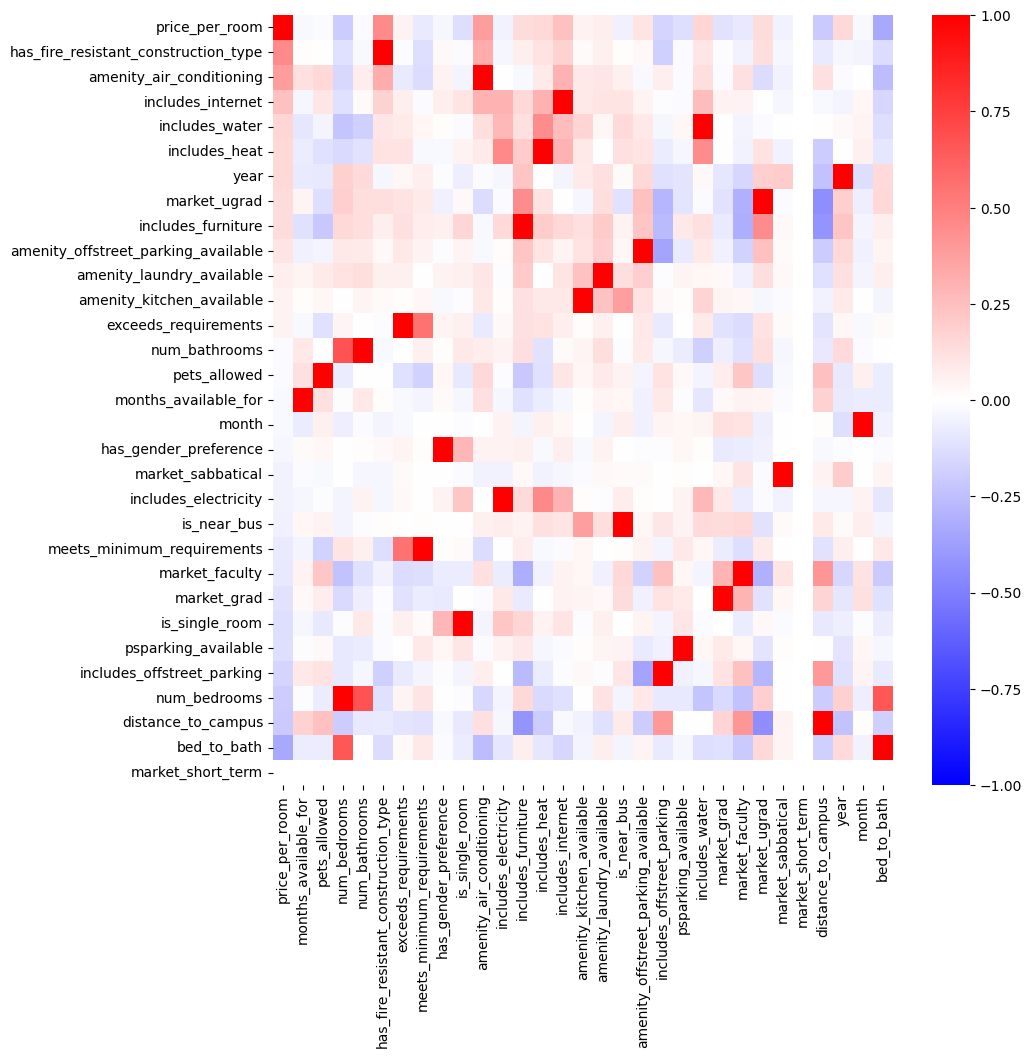

In [6]:
target = df['price_per_room']
regression_cols = ['price_per_room', 'months_available_for', 'pets_allowed',
       'num_bedrooms', 'num_bathrooms', 'has_fire_resistant_construction_type', 
       'exceeds_requirements', 'meets_minimum_requirements', 'has_gender_preference',
       'is_single_room', 'amenity_air_conditioning', 'includes_electricity',
       'includes_furniture', 'includes_heat',
       'includes_internet', 'amenity_kitchen_available',
       'amenity_laundry_available', 'is_near_bus',
       'amenity_offstreet_parking_available', 'includes_offstreet_parking',
       'psparking_available', 'includes_water', 'market_grad',
       'market_faculty', 'market_ugrad', 'market_sabbatical',
       'market_short_term', 'distance_to_campus',
       'year', 'month', 'bed_to_bath']

plt.figure(figsize=(10,10))
ax = sns.heatmap(df[regression_cols].corr().sort_values(by="price_per_room", ascending=False),
            cmap='bwr', norm=colors.CenteredNorm())
plt.show()

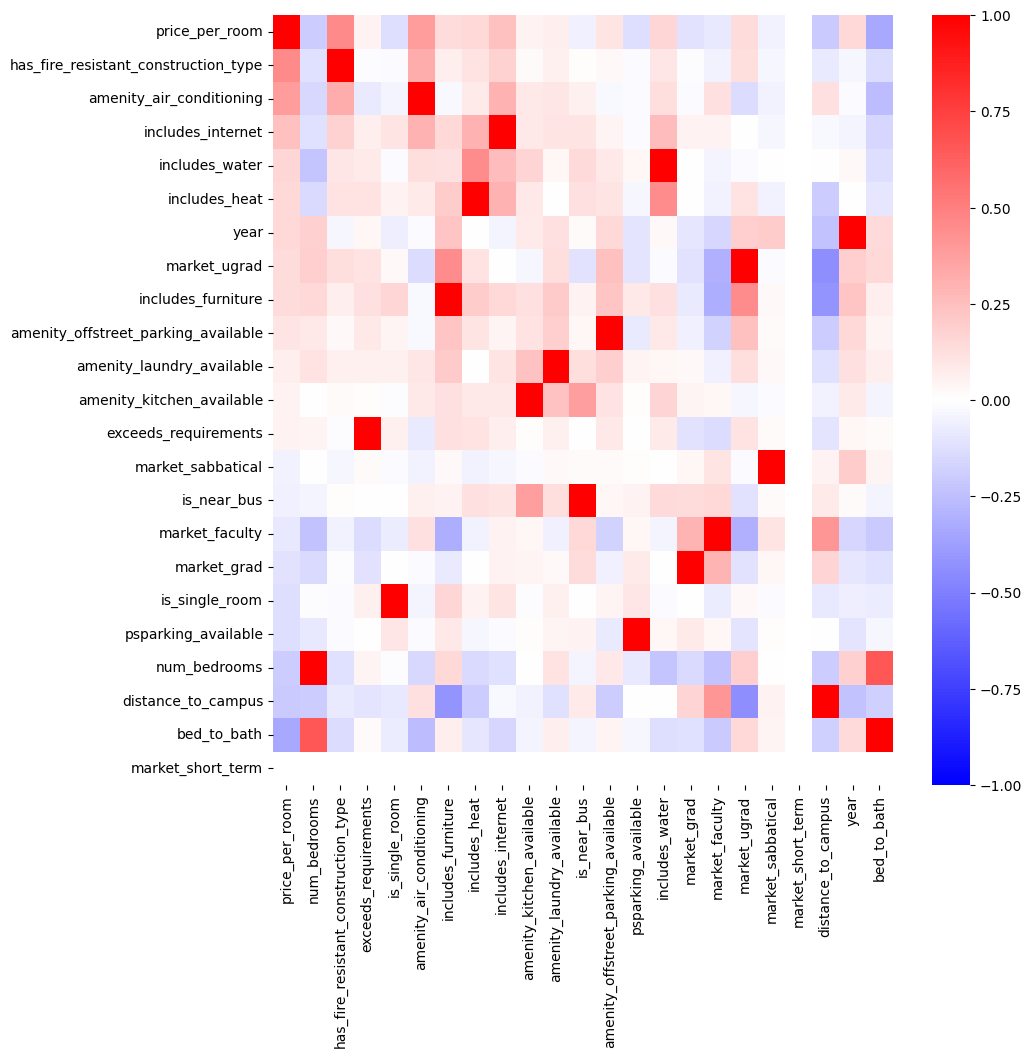

In [7]:
target = df['price_per_room']
regression_cols = ['price_per_room', 
       'num_bedrooms', 'has_fire_resistant_construction_type', 'exceeds_requirements',
       'is_single_room', 'amenity_air_conditioning',
       'includes_furniture', 'includes_heat',
       'includes_internet', 'amenity_kitchen_available',
       'amenity_laundry_available', 'is_near_bus',
       'amenity_offstreet_parking_available',
       'psparking_available', 'includes_water', 'market_grad',
       'market_faculty', 'market_ugrad', 'market_sabbatical',
       'market_short_term', 'distance_to_campus',
       'year', 'bed_to_bath']

plt.figure(figsize=(10,10))
ax = sns.heatmap(df[regression_cols].corr().sort_values(by="price_per_room", ascending=False),
            cmap='bwr', norm=colors.CenteredNorm())
plt.show()

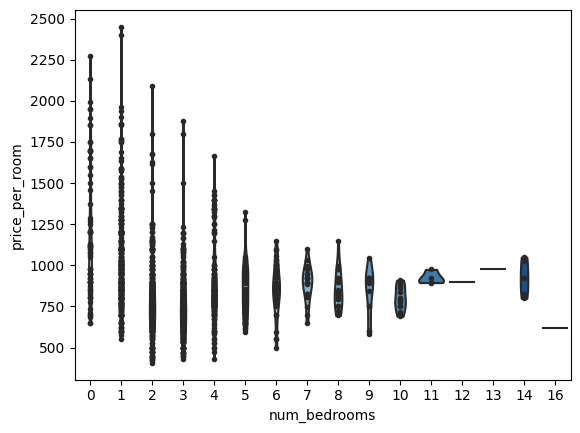

In [8]:
sns.violinplot(data=df, x="num_bedrooms", y="price_per_room", inner="point", cut=0, scale="area",split=True, palette="Blues",discrete=True)
plt.show()

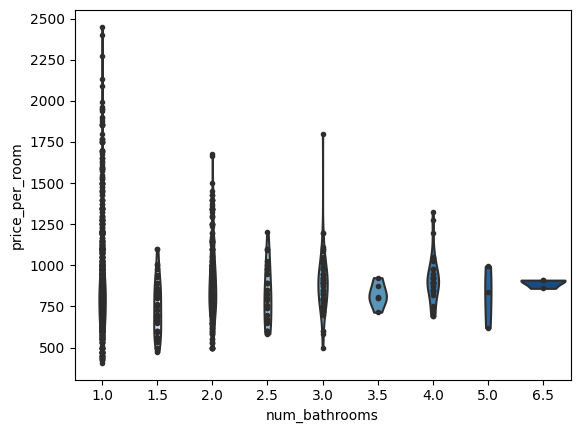

In [9]:
sns.violinplot(data=df, x="num_bathrooms", y="price_per_room", inner="point", cut=0, scale="area",split=True, palette="Blues",discrete=True)
plt.show()

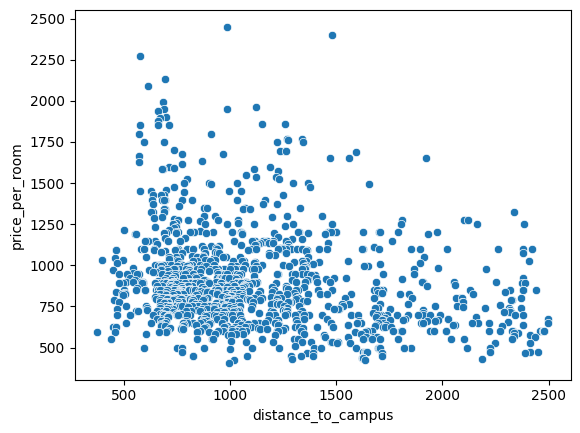

In [10]:
sns.scatterplot(data=df, x="distance_to_campus", y="price_per_room")
plt.show()

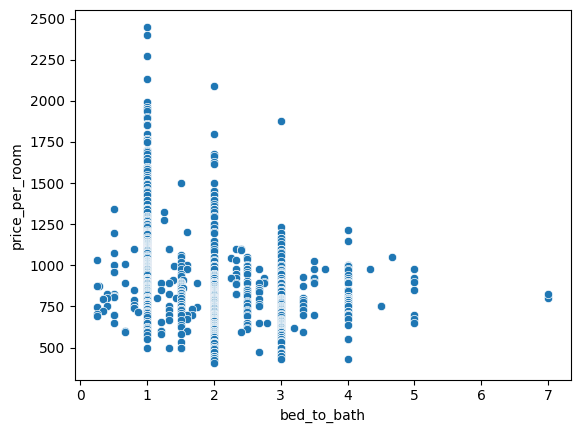

In [11]:
sns.scatterplot(data=df, x="bed_to_bath", y="price_per_room")
plt.show()

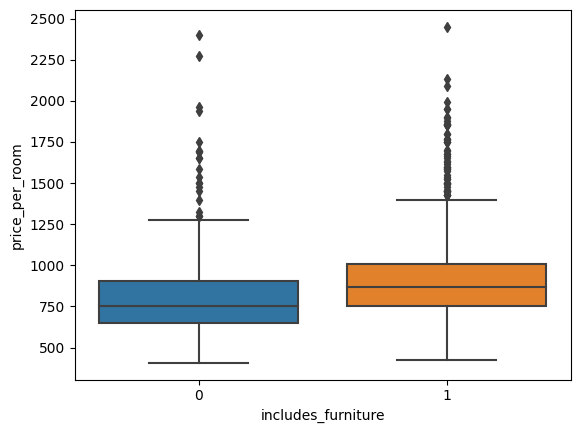

In [12]:
sns.boxplot(data=df, x="includes_furniture", y="price_per_room")
plt.show()

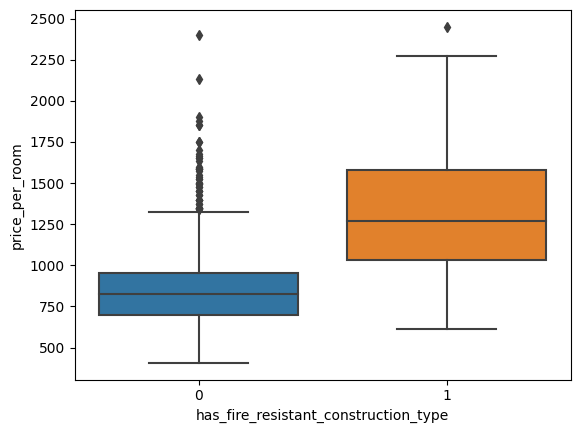

In [13]:
sns.boxplot(data=df, x="has_fire_resistant_construction_type", y="price_per_room")
plt.show()

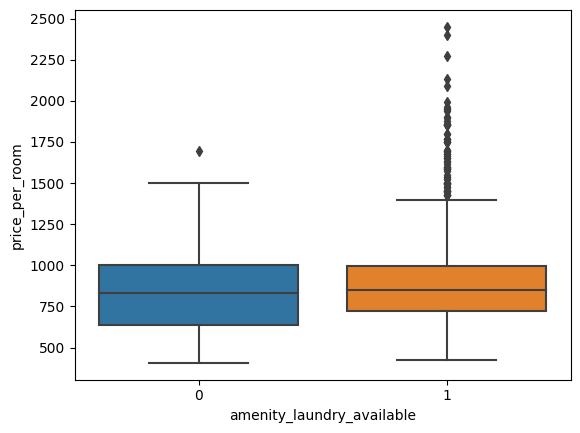

In [14]:
sns.boxplot(data=df, x="amenity_laundry_available", y="price_per_room")
plt.show()

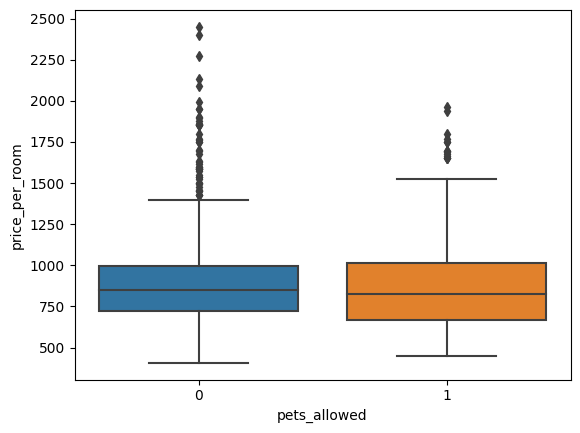

In [15]:
sns.boxplot(data=df, x="pets_allowed", y="price_per_room")
plt.show()

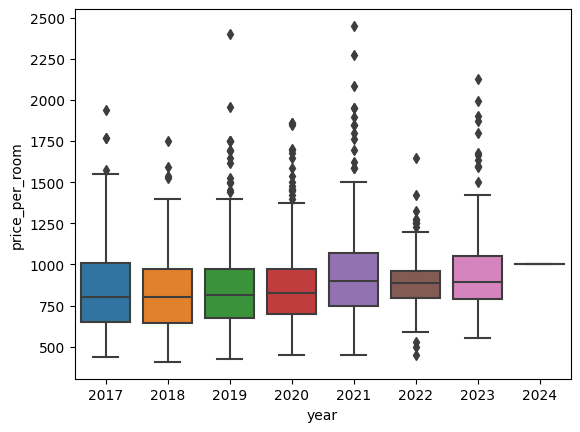

In [16]:
sns.boxplot(data=df, x="year", y="price_per_room")
plt.show()

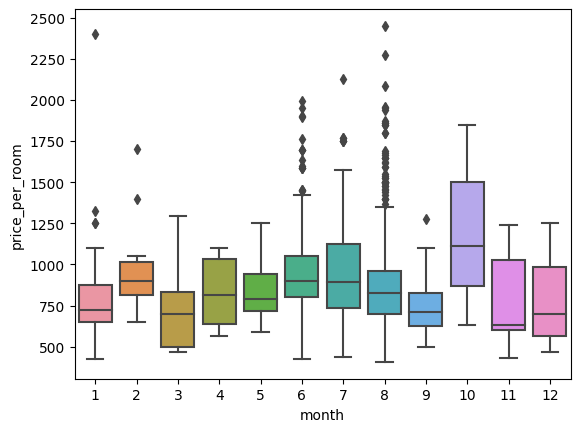

In [17]:
sns.boxplot(data=df, x="month", y="price_per_room")
plt.show()

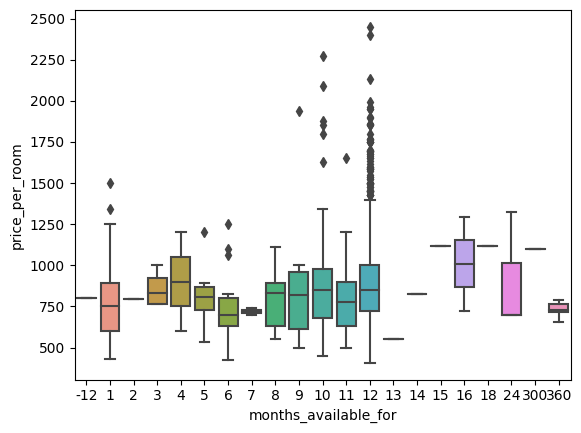

In [18]:
sns.boxplot(data=df, x="months_available_for", y="price_per_room")
plt.show()

In [19]:
features = [
    'num_bedrooms', 'has_fire_resistant_construction_type', 'exceeds_requirements',
    'is_single_room', 'amenity_air_conditioning',
    'includes_furniture', 'includes_heat',
    'includes_internet', 'amenity_kitchen_available',
    'amenity_laundry_available', 'is_near_bus',
    'amenity_offstreet_parking_available',
    'psparking_available', 'includes_water', 'market_grad',
    'market_faculty', 'market_ugrad', 'market_sabbatical',
    'market_short_term', 'distance_to_campus',
    'year', 'bed_to_bath'
]

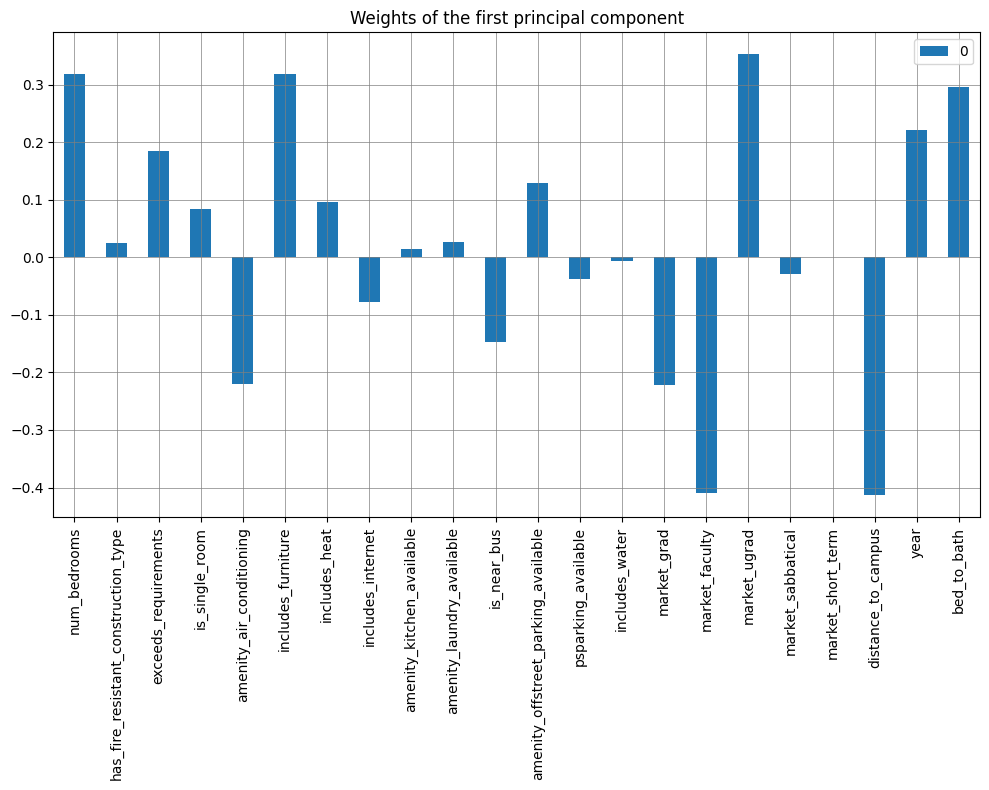

In [26]:
X_train, X_test, y_train, y_test = train_test_split(df[features], target, test_size=0.8, random_state=RANDOM_STATE)
scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
pca = PCA(n_components=2).fit(scaled_X_train)
X_train_std_transformed = pca.transform(scaled_X_train)

first_pca_component = pd.DataFrame(
    pca.components_[0], index=df[features].columns
)
first_pca_component.plot.bar(
    title="Weights of the first principal component", figsize=(10, 8)
)
_ = plt.tight_layout()

plt.grid(which = 'both', axis = 'both', color='grey', linewidth=0.5)

In [37]:
X_train, X_test, y_train, y_test = train_test_split(df[features], target, test_size=0.8, random_state=RANDOM_STATE)
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)


# linear_model = LinearRegression().fit(scaled_X_train, y_train)
lasso = Lasso(random_state=RANDOM_STATE, max_iter=5000, tol=1e-5)                 
params = {
    "alpha": np.logspace(-5, 0, 100)
}
clf = GridSearchCV(lasso, param_grid = params, 
                   scoring = 'neg_mean_absolute_error',
                   n_jobs = -1,
                   cv=20, 
                   refit = True, 
                   verbose = 1)
clf.fit(X_train_scaled, y_train)
print(clf.best_params_)
print(clf.best_score_)
print(clf.best_estimator_.intercept_)
xt
preds = clf.predict(X_test_scaled)
print(mean_absolute_error(preds, y_test))


Fitting 20 folds for each of 100 candidates, totalling 2000 fits
{'alpha': 1.0}
-150.9809196070093
877.2713178298458
157.57809312248983


In [60]:
preds = clf.predict(X_test_scaled)
coefs = clf.best_estimator_.coef_
# coefs[0] = clf.best_estimator_.intercept_


In [ ]:
877.271 + 87.628*8 + 7.950*0 - 41.859*0 + 60.282*0 + 5.389*0 + 11.697*1 +
    0*0 + 9.881*0 + 6.987*1 - 8.868*1 + 16.510*1 - 13.504*1 + 13.832*0 -
    38.543*0 - 2.967*1 + 0.018*0 + 0*1 - 61.969

In [56]:
# X_test[features].iloc[0,:].tolist()
X_test_scaled[0]

array([ 2.61725601, -0.25712974, -0.34891135, -0.36273813, -0.57436653,
        0.54450199, -1.1599373 , -0.58033401,  0.16699834,  0.32025631,
        0.37628835,  0.76342785, -0.53252426, -1.47823719,  0.32756089,
       -1.18794569,  0.60421798, -0.15430335,  0.        , -0.34873906,
        0.66282492,  0.09349539])

In [61]:
np.dot(np.round(coefs, 3),X_test_scaled[0])+clf.best_estimator_.intercept_


860.1791560716474

In [62]:
preds

array([860.18100206, 876.67970541, 992.86667608, ..., 773.3300916 ,
       957.82234553, 786.08613395])

In [63]:
preds[0]

860.1810020590254